In [2]:
import os
import wbgapi as wb
import pandas as pd
import requests
import xml.etree.ElementTree as ET

In [3]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import ydata_profiling

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Carga de índices y lista de paises
# Ruta completa del archivo Excel
ruta_lista_ods = r"C:\JHAA\CEPAL_2\Sustainable_Development_Goals.xlsx"
ruta_lista_devg = r"C:\JHAA\CEPAL_2\Codigos_Indicadores_Desarrollo.xlsx"

# Carga el archivo Excel en un DataFrame de pandas
df_ods = pd.read_excel(ruta_lista_ods)
df_devg = pd.read_excel(ruta_lista_devg)

# Ahora 'df' contiene los datos del archivo Excel
list_ods_id = df_ods["Series Code"].dropna().tolist()
list_devg_id = df_devg["Series Code"].dropna().tolist()

# Valores a eliminar
valores_a_eliminar = ["SL.ISV.IFRM.ZS", "SL.ISV.IFRM.FE.ZS", "SL.ISV.IFRM.MA.ZS"]

# Crea una nueva lista excluyendo los valores a eliminar
list_ods_id = [valor for valor in list_ods_id if valor not in valores_a_eliminar]

# Lista de países
countries = ["ARG", "BHS", "BRB", "BOL", "BRA", "CAN", "COL", "CRI", "CUB", "CHL", "ECU", "SLV", "USA", "FRA", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "NLD", "PAN", "PRY", "PER", "GBR", "DOM", "SUR", "TTO", "URY", "VEN"]

#len(list_ods_id)

In [5]:
###########Carga o descarga de dataset de objetivos de desarrollo sostenible mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_ods = r"C:\JHAA\CEPAL_2\ods_raw.xlsx"

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_ods):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    ods_raw_df = pd.read_excel(ruta_guardado_ods)
else:
    # Si el archivo no existe, realiza la conexión a la base de datos de wb y crea el diccionario de DataFrames
    dfs_ods = {}

    # Ciclo para crear dataframes para cada indicador
    for series_code in list_ods_id:
        # Crea un dataframe para el indicador actual
        df = wb.data.DataFrame(
            series_code,
            countries,
            index="time",
            numericTimeKeys=True,
            labels=True
        )

        # Genera un nombre en la notación "id_ODS"
        dataframe_name = f"{series_code}_ODS"

        # Agrega el DataFrame al diccionario usando el nombre generado como clave
        dfs_ods[dataframe_name] = df

    # Inicializa una lista para almacenar los DataFrames concatenados
    concat_ods_dfs = []

    # Recorre el diccionario dfs_ods
    for dataframe_name, df in dfs_ods.items():
        # Agrega una columna 'series_code' con el valor correspondiente
        df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
        # Agrega el DataFrame actual a la lista
        concat_ods_dfs.append(df)

    # Concatena todos los DataFrames en uno solo
    ods_raw_df = pd.concat(concat_ods_dfs, ignore_index=True)

    # Mueve la columna 'series_code' al primer lugar
    ods_raw_df.insert(0, 'series_code', ods_raw_df.pop('series_code'))

    # Guarda el DataFrame como un archivo Excel en la ubicación especificada
    ods_raw_df.to_excel(ruta_guardado_ods, index=False)
    
    

###########Carga o descarga de dataset de objetivos de desarrollo global mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_devg = r"C:\JHAA\CEPAL_2\devg_raw.xlsx"

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_devg):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    devg_raw_df = pd.read_excel(ruta_guardado_devg)
else:
    # Diccionario para almacenar los DataFrames
    dfs_devg = {}

    # Ciclo para crear dataframes para cada indicador
    for series_code in list_devg_id:
        # Crea un dataframe para el indicador actual
        df = wb.data.DataFrame(
            series_code,
            countries,
            index="time",
            numericTimeKeys=True,
            labels=True
        )

        # Genera un nombre en la notación "id_ODS"
        dataframe_name = f"{series_code}_DEVG"

        # Agrega el DataFrame al diccionario usando el nombre generado como clave
        dfs_devg[dataframe_name] = df

        # Inicializa una lista para almacenar los DataFrames concatenados
        concat_devg_dfs = []

    # Recorre el diccionario dfs_ods
    for dataframe_name, df in dfs_devg.items():
        # Agrega una columna 'series_code' con el valor correspondiente
        df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
        # Agrega el DataFrame actual a la lista
        concat_devg_dfs.append(df)

    # Concatena todos los DataFrames en uno solo
    devg_raw_df = pd.concat(concat_devg_dfs, ignore_index=True)

    # Mueve la columna 'series_code' al primer lugar
    devg_raw_df.insert(0, 'series_code', devg_raw_df.pop('series_code'))

    # Guarda el DataFrame como un archivo Excel en la ubicación especificada
    devg_raw_df.to_excel(ruta_guardado_devg, index=False)
    
    
    
###########Carga o descarga de dataset de indicadores de corrupción mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_corr = r"C:\JHAA\CEPAL_2\corr_raw.xlsx"
  
#extraer lista de indicadores de corrupción
# URL del documento XML
url = "https://api.worldbank.org/v2/sources/3/indicators"

# Realiza una solicitud HTTP para obtener el contenido del enlace
response = requests.get(url)

# Verifica si la solicitud fue exitosa (código de respuesta 200)
if response.status_code == 200:
    # Parsea el contenido XML
    xml_content = response.content
    root = ET.fromstring(xml_content)

    # Inicializa una lista para almacenar los elementos 'indicator'
    list_corr_id = []

    # Itera a través de los elementos 'indicator' en el árbol XML
    for indicator in root.findall(".//wb:indicator", namespaces={"wb": "http://www.worldbank.org"}):
        # Obtiene el valor del atributo 'id' y el texto dentro del elemento 'wb:name'
        indicator_id = indicator.get("id")
        indicator_name = indicator.find("wb:name", namespaces={"wb": "http://www.worldbank.org"}).text

        # Almacena los datos en un diccionario
        indicator_data = {
            "id": indicator_id,
            "name": indicator_name
        }

        # Agrega el diccionario a la lista de indicadores
        list_corr_id.append(indicator_data)

# Código para obtener indicadores adicionales si es necesario
# ...

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_corr):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    corr_raw_df = pd.read_excel(ruta_guardado_corr)
else:

        dfs_corr = {}

        # Ciclo para crear dataframes para cada indicador
        for indicator_data in list_corr_id:
            indicator_id = indicator_data["id"]

            # Crea un dataframe para el indicador actual
            df = wb.data.DataFrame(
                indicator_id,
                countries,
                index="time",
                numericTimeKeys=True,
                labels=True
            )

            # Genera un nombre en la notación "id_cepal"
            dataframe_name = f"{indicator_id}_CORR"

            # Agrega el DataFrame al diccionario usando el nombre generado como clave
            dfs_corr[dataframe_name] = df

        # Inicializa una lista para almacenar los DataFrames concatenados
        concat_corr_dfs = []

        # Recorre el diccionario dfs_corr
        for dataframe_name, df in dfs_corr.items():
            # Agrega una columna 'series_code' con el valor correspondiente
            df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
            # Agrega el DataFrame actual a la lista
            concat_corr_dfs.append(df)

        # Concatena todos los DataFrames en uno solo
        corr_raw_df = pd.concat(concat_corr_dfs, ignore_index=True)

        # Mueve la columna 'series_code' al primer lugar
        corr_raw_df.insert(0, 'series_code', corr_raw_df.pop('series_code'))

        # Guarda el DataFrame como un archivo Excel en la ubicación especificada
        corr_raw_df.to_excel(ruta_guardado_corr, index=False)

In [6]:
# Lista para almacenar los nuevos DataFrames sin filas de NaN
clnd_dfs = []

raw_dfs = [ods_raw_df, devg_raw_df, corr_raw_df]

for df in raw_dfs:
    # Copia el DataFrame original para mantenerlo intacto
    nuevo_df = df.copy()
    
    # Guarda las filas eliminadas en otro DataFrame
    filas_eliminadas = nuevo_df[nuevo_df.iloc[:, 2:34].isnull().all(axis=1)]
    
    ## Elimina las filas con todos los valores NaN
    nuevo_df.dropna(subset=nuevo_df.columns[2:34], how='all', inplace=True)
    
    # Agrega el nuevo DataFrame a la lista de nuevos DataFrames
    clnd_dfs.append(nuevo_df)
    
#######paises
## Diccionario para almacenar los resultados
nan_info_dict = {}

# Itera a través de la lista de DataFrames sin filas de NaN (clnd_dfs)
for i, df in enumerate(clnd_dfs):
    # Calcula la cantidad de datos NaN por cada columna en el DataFrame
    nan_count_per_column = df.isna().sum()
    
    # Calcula el porcentaje de datos perdidos en cada columna
    total_rows = len(df)
    nan_percentage_per_column = (nan_count_per_column / total_rows) * 100
    
    # Almacena la información en un DataFrame
    nan_info_df = pd.DataFrame({
        "NaN_Count": nan_count_per_column,
        "NaN_Percentage": nan_percentage_per_column
    })
    
    # Ordena el DataFrame por la columna "NaN_Count" en orden descendente
    nan_info_df = nan_info_df.sort_values(by="NaN_Count", ascending=False)
    
    # Agrega el DataFrame con la información al diccionario
    nan_info_dict[f"clean_{i + 1}"] = nan_info_df

# Obtener el DataFrame correspondiente a clean_ods_df en nan_info_dict (por índice)
nan_info_clean_ods = list(nan_info_dict.values())[0]

#### Filtrar las columnas con porcentaje superior al 26.0
columns_to_exclude = nan_info_clean_ods[nan_info_clean_ods["NaN_Percentage"] > 26.0].index.tolist()

# Eliminar las columnas coincidentes de los dos primeros DataFrames en clnd_dfs
for i in range(2):
    clnd_dfs[i] = clnd_dfs[i].drop(columns=columns_to_exclude)

# Crear el nuevo DataFrame excluded_corr a partir de clnd_dfs[2]
excluded_corr = clnd_dfs[2][columns_to_exclude]

# Eliminar las columnas coincidentes de clnd_dfs[2]
clnd_dfs[2] = clnd_dfs[2].drop(columns=columns_to_exclude)

# Almacenar los DataFrames en sus variables originales (opcional)
clnd_dfs.append(excluded_corr)

##########indicadores

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "series_code"
    unique_series_codes = df["series_code"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_series = {}

    # Filtra el DataFrame por cada valor único en "series_code" y calcula el porcentaje de NaN
    for series_code in unique_series_codes:
        filtered_df = df[df["series_code"] == series_code]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_series[series_code] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_series

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs

# Crear listas de series_code que tengan un porcentaje superior a 26.0 en los tres primeros DataFrames de clnd_dfs
series_codes_to_exclude = set()

# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    for series_code, nan_percentage in nan_percentage_dict[f"clean_{i + 1}"].items():
        if nan_percentage > 26.0:
            series_codes_to_exclude.add(series_code)

# Filtrar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["series_code"].isin(series_codes_to_exclude)]

# Ahora clnd_dfs contiene los DataFrames sin las filas con series_code con porcentaje superior a 26.0 en los tres primeros DataFrames



#######años

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "Year"
    unique_years = df["Time"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_year = {}

    # Filtra el DataFrame por cada valor único en "Year" y calcula el porcentaje de NaN
    for year in unique_years:
        filtered_df = df[df["Time"] == year]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_year[year] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_year

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs


# Crear una lista para almacenar los años con porcentaje superior a 26.0
years_to_exclude = []

# Iterar a través del nan_percentage_dict
for i in range(3):
    nan_percentage_per_year = nan_percentage_dict[f"clean_{i + 1}"]
    for year, nan_percentage in nan_percentage_per_year.items():
        if nan_percentage > 26.0 and year not in years_to_exclude:
            years_to_exclude.append(year)

# Eliminar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["Time"].isin(years_to_exclude)]
    
# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    df = clnd_dfs[i]  # Obtén el DataFrame actual
    unique_series_codes = df["series_code"].unique()  # Obtiene los valores únicos en "series_code"

    # Iterar a través de los valores únicos en "series_code"
    for series_code in unique_series_codes:
        # Filtra el DataFrame por el valor único en "series_code" y copia el resultado
        filtered_df = df[df["series_code"] == series_code].copy()
        
        # Calcula la mediana por columna en el subconjunto de datos y reemplaza NaN por la mediana
        median_values = filtered_df.median(numeric_only=True)  # Calcula la mediana por columna
        filtered_df.fillna(median_values, inplace=True)  # Reemplaza NaN por la mediana en el DataFrame copiado

        # Actualiza el DataFrame original con los valores reemplazados
        df.update(filtered_df)

# Ahora, clnd_dfs contiene los DataFrames originales con los valores NaN reemplazados por las medianas correspondientes en cada serie_code




In [7]:
#guardar dataframes consolidado de indicadores
clean_ods_df = clnd_dfs[0]  # Primer DataFrame en la lista
clean_devg_df = clnd_dfs[1]  # Segundo DataFrame en la lista
clean_corr_df = clnd_dfs[2]  # Tercer DataFrame en la lista

# Crea un diccionario con los nombres de los DataFrames y los nombres de archivo correspondientes
dataframes_dict = {
    "clean_ods": clean_ods_df,
    "clean_devg": clean_devg_df,
    "clean_corr": clean_corr_df
}

# Define la ruta de guardado con un nombre de archivo (reemplaza [nombre_archivo] con el nombre deseado)
ruta_guardado_base = r"C:\JHAA\CEPAL_2\nombre_archivo.xlsx"

# Itera sobre el diccionario y verifica si los archivos ya existen
for nombre_df, df in dataframes_dict.items():
    # Genera la ruta completa del archivo Excel
    ruta_guardado = ruta_guardado_base.replace("nombre_archivo", nombre_df)
    
    # Verifica si el archivo ya existe en el directorio
    if os.path.exists(ruta_guardado):
        # Si el archivo existe, carga el DataFrame desde el archivo Excel
        df_loaded = pd.read_excel(ruta_guardado)
        
        # Puedes asignar df_loaded a una variable específica si es necesario
        # Por ejemplo, si quieres reemplazar el DataFrame original
        # clean_ods_df = df_loaded

        ##print(f"El archivo {ruta_guardado} ya existe. Cargando DataFrame...")
    else:
        # Si el archivo no existe, guarda el DataFrame como un archivo Excel
        df.to_excel(ruta_guardado, index=False)
        ##print(f"Guardando DataFrame en {ruta_guardado}")

##print("Operación completada.")

In [8]:
clean_ods_df

,series_code,Time,ARG,BOL,BRA,CAN,CHL,COL,CRI,DOM,...,FRA,GBR,HND,MEX,NLD,PAN,PER,PRY,URY,USA
1,FX.OWN.TOTL.ZS,2021,71.63000,68.89000,84.04000,99.63000,87.06000,59.72000,68.49000,51.30000,...,99.24000,99.76000,37.85000,36.93000,99.73000,44.97000,57.50000,54.42000,74.13000,94.95000
5,FX.OWN.TOTL.ZS,2017,48.71000,54.41000,70.04000,99.73000,74.35000,45.76000,67.84000,56.24000,...,94.00000,96.37000,45.34000,36.93000,99.64000,46.49000,42.60000,48.65000,63.87000,93.12000
8,FX.OWN.TOTL.ZS,2014,50.20000,41.80000,68.12000,99.10000,63.26000,39.00000,64.55000,54.09000,...,96.58000,98.93000,31.49000,39.14000,99.30000,43.66000,28.98000,48.65000,45.59000,93.58000
11,FX.OWN.TOTL.ZS,2011,33.13000,28.03000,55.86000,95.80000,42.18000,30.43000,50.36000,38.20000,...,96.98000,97.20000,20.51000,27.43000,98.66000,24.93000,20.46000,21.72000,23.54000,87.96000
64,FX.OWN.TOTL.FE.ZS,2021,73.75000,63.29000,80.87000,99.51000,86.62000,56.20000,61.08000,48.96000,...,100.00000,99.91000,28.85000,33.29000,99.47000,43.11000,53.03000,55.35000,75.73000,96.79000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,SL.EMP.WORK.ZS,1995,70.64411,29.79128,62.58083,84.33201,69.93645,51.22395,71.38242,58.31049,...,86.35035,86.52421,47.06759,58.47977,87.29871,67.46220,40.50494,46.42667,72.43121,91.44275
2989,SL.EMP.WORK.ZS,1994,70.21136,29.67550,62.19880,84.46677,69.58295,51.08644,71.86321,60.22966,...,85.89227,86.57585,46.96130,57.24591,87.60827,68.71156,40.17160,46.09461,72.52728,91.20032
2990,SL.EMP.WORK.ZS,1993,68.79981,29.59965,61.99662,84.27937,69.45956,50.94876,71.89772,57.72234,...,85.84666,86.90589,47.06789,55.25315,88.24348,66.91835,39.70478,45.95954,72.34369,91.18237
2991,SL.EMP.WORK.ZS,1992,70.15132,29.56382,61.83287,84.85941,69.26433,50.84572,71.92434,55.72599,...,84.92098,86.77021,46.99247,54.91980,88.61496,65.05959,39.62067,45.87067,72.33452,91.30321


In [9]:
def create_filtered_dataframes(original_df):
    # Obtiene los valores únicos de la columna 'series_code'
    unique_series_codes = original_df['series_code'].unique()

    # Diccionario para almacenar los nuevos DataFrames
    new_dfs = {}

    for series_code in unique_series_codes:
        
        original_df['Time'] = original_df['Time'].astype(int)
        
        
        # Filtra el DataFrame original por 'series_code'
        filtered_df = original_df[original_df['series_code'] == series_code]
        
        
        # Obtén los nombres de las columnas en lugar de los valores de la columna "Time"
        nombres_columnas = list(filtered_df.columns[2:])
        
        # Crear un DataFrame para almacenar datos
        transposed_df = pd.DataFrame()
        
        for country in nombres_columnas:
            
            slide_df = pd.DataFrame()
            slide_df["Year"] = filtered_df['Time']
            slide_df[series_code] = filtered_df[country]
            slide_df["Country"] = country

            # Reorganizar las columnas
            slide_df = slide_df[['Country', 'Year', series_code]]

            # Utiliza el método concat para agregar slide_df a transposed_df
            transposed_df = pd.concat([transposed_df, slide_df], ignore_index=True)
                                      
        # Almacena el DataFrame transpuesto en el diccionario new_dfs
        new_dfs[series_code] = transposed_df

    return new_dfs

dataframe_dict1 = create_filtered_dataframes(clean_corr_df)
dataframe_dict2 = create_filtered_dataframes(clean_ods_df)
dataframe_dict3 = create_filtered_dataframes(clean_devg_df)

In [10]:
# Función para unir DataFrames y devolver el DataFrame resultante
def merge_dataframes(dataframe_dict):
    # Inicializa el DataFrame resultante con las primeras 2 columnas
    result_df = pd.DataFrame({'Country': [], 'Year': []})
    
    # Realiza una unión externa (outer join) de todos los DataFrames en el diccionario
    for series_code, df in dataframe_dict.items():
        result_df = pd.merge(result_df, df, on=['Country', 'Year'], how='outer')
    
    # Reordena las columnas para tener 'Country' y 'Year' al principio
    result_columns = ['Country', 'Year'] + [col for col in result_df.columns if col not in ['Country', 'Year']]
    result_df = result_df[result_columns]
    
    # Devuelve el DataFrame resultante
    return result_df

# Llama a la función para unir DataFrames y obtener el resultado
result_df1 = merge_dataframes(dataframe_dict1)
result_df2 = merge_dataframes(dataframe_dict2)
result_df3 = merge_dataframes(dataframe_dict3)



####
# Obtener la lista de valores únicos en la columna 'Year' de result_df1
unique_years = result_df1['Year'].unique()

# Filtrar result_df2 y result_df3 para que solo contengan los valores coincidentes en la columna 'Year'
result_df2 = result_df2[result_df2['Year'].isin(unique_years)]
result_df3 = result_df3[result_df3['Year'].isin(unique_years)]
# Elimina las columnas desde la posición 3 hasta 12 (índice 3 al 12) en result_df2
result_df2 = result_df2.drop(result_df2.columns[2:11], axis=1)

####
columns_to_remove_corr = [
    'CC.NO.SRC', 'CC.PER.RNK.LOWER', 'CC.PER.RNK.UPPER', 'CC.STD.ERR', 'CC.PER.RNK',
    'GE.NO.SRC', 'GE.PER.RNK.LOWER', 'GE.PER.RNK.UPPER', 'GE.STD.ERR', 'GE.PER.RNK',
    'PV.NO.SRC', 'PV.PER.RNK.LOWER', 'PV.PER.RNK.UPPER', 'PV.STD.ERR', 'PV.PER.RNK',
    'RQ.NO.SRC', 'RQ.PER.RNK.LOWER', 'RQ.PER.RNK.UPPER', 'RQ.STD.ERR', 'RL.PER.RNK',
    'RL.NO.SRC', 'RL.PER.RNK.LOWER', 'RL.PER.RNK.UPPER', 'RL.STD.ERR', 'RQ.PER.RNK',
    'VA.NO.SRC', 'VA.PER.RNK.LOWER', 'VA.PER.RNK.UPPER', 'VA.STD.ERR', 'VA.PER.RNK'
]

result_df1 = result_df1.drop(columns=columns_to_remove_corr)



columns_to_remove_ods = [
    'FB.CBK.BRCH.P5', 'SL.GDP.PCAP.EM.KD'
]

result_df2 = result_df2.drop(columns=columns_to_remove_ods)



columns_to_remove_devg = [
    'BX.KLT.DINV.WD.GD.ZS', 'BM.KLT.DINV.WD.GD.ZS', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.KD', 'NY.GDP.PCAP.CD',
    'SL.UEM.TOTL.ZS', 'SL.UEM.1524.ZS'
]

result_df3 = result_df3.drop(columns=columns_to_remove_devg)

####
# Función para reemplazar NaN por la mediana de cada columna dentro de cada grupo 'Country'
def replace_nan_with_column_median(df):
    return df.fillna(df.median(numeric_only=True))

# Función para procesar un DataFrame
def process_dataframe(df):
    # Filtrar por cada elemento de la columna 'Country' y reemplazar los NaN por la mediana de cada columna
    df = df.groupby('Country').apply(replace_nan_with_column_median)
    
    # Reemplazar los valores faltantes restantes con cero en todo el DataFrame
    df.fillna(0, inplace=True)
    
    # Reiniciar los índices después del groupby
    df = df.reset_index(drop=True)
    
    return df

# Supongamos que result_df2 y result_df3 son tus DataFrames con NaN
result_df2 = process_dataframe(result_df2)
result_df3 = process_dataframe(result_df3)

####
# Función para ordenar un DataFrame por 'Country' en orden alfabético y 'Year' en orden descendente
def sort_dataframe(df):
    return df.sort_values(by=['Country', 'Year'], ascending=[True, False])

# Supongamos que result_df1, result_df2 y result_df3 son tus DataFrames

result_df1 = sort_dataframe(result_df1)
result_df2 = sort_dataframe(result_df2)
result_df3 = sort_dataframe(result_df3)


main_subset = result_df1.iloc[:, :2]

# Extraer solo las dos primeras columnas de result_df2
result_df1_subset = result_df1.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df2
result_df2_subset = result_df2.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df3
result_df3_subset = result_df3.iloc[:, 2:]

# Agregar prefijo a las columnas de result_df1
result_df1_subset = result_df1_subset.add_prefix("CRP_")

# Agregar prefijo a las columnas de result_df2
result_df2_subset = result_df2_subset.add_prefix("ODS_")

# Agregar prefijo a las columnas de result_df3
result_df3_subset = result_df3_subset.add_prefix("GDE_")


In [11]:
### transformación para análisis de datos
# Supongamos que tienes un DataFrame llamado merged_df

# Concatenar las dos primeras columnas de los tres DataFrames en uno solo
merged_df = pd.concat([main_subset,result_df1_subset, result_df2_subset, result_df3_subset], axis=1)

# Lista de nombres de las columnas desde la tercera columna en adelante
columnas_a_normalizar = merged_df.columns[2:]

# Realizar el Escalamiento Min-Max
for columna in columnas_a_normalizar:
    min_valor = merged_df[columna].min()
    max_valor = merged_df[columna].max()
    merged_df[columna] = (merged_df[columna] - min_valor) / (max_valor - min_valor)
    

    

relaciones_global_cols  = ["Country","Year","CRP_CC.EST", "CRP_GE.EST", "CRP_RL.EST", "CRP_RQ.EST", "CRP_VA.EST", 
                      "GDE_SL.GDP.PCAP.EM.KD"]

relaciones_colombia_cols = ["Country","Year","CRP_GE.EST", "CRP_PV.EST", "CRP_RL.EST", "CRP_RQ.EST", "CRP_VA.EST",
                      "GDE_SL.GDP.PCAP.EM.KD",
                      "ODS_SL.IND.EMPL.ZS",
                      "GDE_NY.GDP.MKTP.CD",
                      "GDE_BX.KLT.DINV.CD.WD",
                      "ODS_NV.SRV.EMPL.KD",
                           "ODS_NV.IND.EMPL.KD"]

relaciones_latam_cols = ["Country","Year","CRP_CC.EST", "CRP_GE.EST", "CRP_PV.EST", "CRP_RL.EST", "CRP_RQ.EST", "CRP_VA.EST",
                   "GDE_SL.GDP.PCAP.EM.KD"]

merged_global = merged_df[relaciones_global_cols]

merged_colombia = merged_df[relaciones_colombia_cols]
    
merged_latam = merged_df[relaciones_latam_cols]



In [12]:
merged_df

,Country,Year,CRP_CC.EST,CRP_GE.EST,CRP_PV.EST,CRP_RL.EST,CRP_RQ.EST,CRP_VA.EST,ODS_NV.AGR.EMPL.KD,ODS_SL.AGR.EMPL.ZS,...,ODS_SL.UEM.1524.ZS,ODS_SL.EMP.WORK.FE.ZS,ODS_SL.EMP.WORK.MA.ZS,ODS_SL.EMP.WORK.ZS,GDE_BM.KLT.DINV.CD.WD,GDE_BN.KLT.DINV.CD,GDE_BX.KLT.DINV.CD.WD,GDE_EG.GDP.PUSE.KO.PP,GDE_NY.GDP.MKTP.CD,GDE_SL.GDP.PCAP.EM.KD
0,ARG,2021,0.282113,0.227405,0.574767,0.238664,0.190353,0.535354,0.073032,0.160150,...,0.530293,0.702971,0.632807,0.648013,0.328283,0.650586,0.316907,0.268093,0.020678,0.323422
1,ARG,2020,0.353990,0.270069,0.557234,0.235350,0.230614,0.524047,0.994809,0.167084,...,0.516002,0.778549,0.658583,0.699023,0.327877,0.653760,0.315010,0.268093,0.016316,0.331512
2,ARG,2019,0.369795,0.311881,0.550985,0.254004,0.244334,0.518002,0.106191,0.182910,...,0.417924,0.804781,0.684017,0.725397,0.328267,0.651044,0.316669,0.268093,0.018985,0.342874
3,ARG,2018,0.372095,0.358601,0.576301,0.318523,0.322264,0.504400,0.093208,0.196789,...,0.406894,0.815669,0.691022,0.734099,0.328496,0.641738,0.321431,0.268093,0.022291,0.359720
4,ARG,2017,0.313666,0.392174,0.613966,0.312714,0.322166,0.499795,1.000000,0.162274,...,0.595042,0.752066,0.647338,0.680769,0.327852,0.641029,0.321243,0.268093,0.027388,0.379654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,USA,2003,0.873487,0.833440,0.594109,0.869786,0.857093,0.846513,0.024305,0.022385,...,0.226753,0.987089,0.975500,0.980184,0.546980,0.810288,0.420465,0.109548,0.491261,0.776036
433,USA,2002,0.920509,0.858816,0.643698,0.858120,0.852009,0.849229,0.025321,0.029922,...,0.156569,0.983789,0.972899,0.977000,0.528650,0.790808,0.414779,0.097856,0.468638,0.754660
434,USA,2000,0.845432,0.891463,0.836537,0.872950,0.895771,0.834495,0.019276,0.037233,...,0.186478,0.981951,0.963448,0.971055,0.536989,0.349485,0.638494,0.080195,0.439545,0.728423
435,USA,1998,0.830361,0.883185,0.787393,0.873673,0.869679,0.845935,0.028824,0.040805,...,0.230147,0.975693,0.955056,0.963271,0.523880,0.591234,0.508839,0.064440,0.388574,0.685495


In [31]:
# Elimina la columna 'Country' de merged_df
merged_df1 = merged_df.drop(columns=['Country'])

# Genera la matriz de correlación
correlaciones = merged_df1.corr()

# Filtra las correlaciones mayores a 0.75
correlaciones_altas = correlaciones[(correlaciones > 0.75) & (correlaciones < 1.0)]

# Retira las filas correspondientes a las columnas de interés
filas_de_interes = [columna for columna in merged_df.columns if columna.startswith('CRP_')]

correlaciones_altas = correlaciones_altas.drop(index=filas_de_interes)

# Retira las columnas que no están en la lista de filas_de_interes
correlaciones_altas = correlaciones_altas[filas_de_interes]

# Elimina las filas que tengan datos perdidos en todas las columnas
correlaciones_altas = correlaciones_altas.dropna(how='all')

# Obtener elementos únicos en los índices y nombres de columnas
elementos_unicos = list(set(correlaciones_altas.index) | set(correlaciones_altas.columns))

reduced_df = merged_df[['Country', 'Year'] + elementos_unicos]

# Visualiza las correlaciones altas sin las filas de interés y con columnas de interés
print(reduced_df)

    Country  Year  ODS_SL.EMP.WORK.FE.ZS  CRP_VA.EST  CRP_CC.EST  \
0       ARG  2021               0.702971    0.535354    0.282113   
1       ARG  2020               0.778549    0.524047    0.353990   
2       ARG  2019               0.804781    0.518002    0.369795   
3       ARG  2018               0.815669    0.504400    0.372095   
4       ARG  2017               0.752066    0.499795    0.313666   
..      ...   ...                    ...         ...         ...   
432     USA  2003               0.987089    0.846513    0.873487   
433     USA  2002               0.983789    0.849229    0.920509   
434     USA  2000               0.981951    0.834495    0.845432   
435     USA  1998               0.975693    0.845935    0.830361   
436     USA  1996               0.994783    0.850981    0.836379   

     ODS_SL.EMP.WORK.MA.ZS  CRP_GE.EST  GDE_SL.GDP.PCAP.EM.KD  CRP_RQ.EST  \
0                 0.632807    0.227405               0.323422    0.190353   
1                 0.658583   

In [33]:
import pandas as pd

# Supongamos que reduced_df es el DataFrame que se desea guardar
# Asegúrate de que reduced_df esté definido y tenga los datos necesarios.

# ... Código para crear o cargar reduced_df ...

# Ruta para guardar el DataFrame en un archivo CSV
ruta_guardado_csv = r'C:\JHAA\CEPAL_2\reduced_df.csv'

# Guardar el DataFrame en un archivo CSV
reduced_df.to_csv(ruta_guardado_csv, index=False)  # El parámetro index=False evita la escritura del índice en el archivo CSV


In [15]:
import pandas as pd
from scipy import stats

# Definir el nivel de significancia (alfa)
alpha = 0.05

# Crear un DataFrame para almacenar los resultados
resultados_normalidad = pd.DataFrame(columns=['Variable', 'Estadístico', 'Valor Crítico', 'Conclusión'])

# Obtener las columnas numéricas (excluyendo 'Country' y 'Year')
columnas_numericas = [col for col in reduced_df.columns if col not in ['Country', 'Year']]

for columna in columnas_numericas:
    result = stats.anderson(reduced_df[columna], dist='norm')
    statistic = result.statistic
    critical_values = result.critical_values
    significance_level = result.significance_level
    conclusion = "Normal" if statistic < critical_values[2] else "No Normal"
    
    nueva_fila = {
        'Variable': columna,
        'Estadístico': statistic,
        'Valor Crítico': critical_values[2],
        'Conclusión': conclusion
    }
    
    resultados_normalidad = pd.concat([resultados_normalidad, pd.DataFrame([nueva_fila])], ignore_index=True)

print("Resultados de normalidad:")
print(resultados_normalidad)


Resultados de normalidad:
                 Variable  Estadístico  Valor Crítico Conclusión
0   GDE_SL.GDP.PCAP.EM.KD    18.257534           0.78  No Normal
1              CRP_GE.EST    15.094401           0.78  No Normal
2              CRP_RL.EST    20.925600           0.78  No Normal
3   ODS_SL.SRV.EMPL.MA.ZS     1.365280           0.78  No Normal
4      ODS_NV.SRV.EMPL.KD    43.644956           0.78  No Normal
5      ODS_NV.IND.EMPL.KD    34.195464           0.78  No Normal
6              CRP_PV.EST     1.579737           0.78  No Normal
7              CRP_RQ.EST     5.742889           0.78  No Normal
8   ODS_SL.EMP.WORK.MA.ZS     4.861128           0.78  No Normal
9      ODS_SL.EMP.WORK.ZS     5.327414           0.78  No Normal
10  ODS_SL.EMP.WORK.FE.ZS     9.497429           0.78  No Normal
11             CRP_CC.EST    22.313670           0.78  No Normal
12             CRP_VA.EST    10.594579           0.78  No Normal
13     ODS_SL.SRV.EMPL.ZS     2.826787           0.78  No Normal

In [18]:
#import pandas as pd
#from scipy.stats import spearmanr

# Dataframe con las variables de interés
#data = reduced_df[['GDE_SL.GDP.PCAP.EM.KD', 'CRP_CC.EST', 'CRP_GE.EST', 'CRP_PV.EST', 'CRP_RL.EST', 'CRP_RQ.EST', 'CRP_VA.EST', 'Year']]

# Crear un dataframe vacío para almacenar los resultados de correlación
#correlation_results = pd.DataFrame(columns=['Variable', 'Correlación'])

# Calcular la correlación de Spearman para cada variable
#for variable in data.columns[1:]:
#    corr, _ = spearmanr(data['GDE_SL.GDP.PCAP.EM.KD'], data[variable])
#    correlation_results = pd.concat([correlation_results, pd.DataFrame({'Variable': [variable], 'Correlación': [corr]})], ignore_index=True)

# Filtrar la correlación consigo misma
#correlation_results = correlation_results[correlation_results['Variable'] != 'GDE_SL.GDP.PCAP.EM.KD']

# Imprimir los resultados
#print(correlation_results)



In [19]:
import pandas as pd
from scipy.stats import spearmanr

# Crear un DataFrame vacío para almacenar los resultados de correlación
correlation_results = pd.DataFrame(columns=['Variable', 'Correlación', 'Valor p'])

# Calcular la correlación de Spearman para cada variable
for variable in data.columns[1:]:
    corr, p_value = spearmanr(data['GDE_SL.GDP.PCAP.EM.KD'], data[variable])
    new_row = {'Variable': variable, 'Correlación': corr, 'Valor p': p_value}
    correlation_results = pd.concat([correlation_results, pd.DataFrame([new_row])], ignore_index=True)

# Filtrar la correlación consigo misma
# correlation_results = correlation_results[correlation_results['Variable'] != 'GDE_SL.GDP.PCAP.EM.KD']

# Imprimir los resultados
print(correlation_results)



NameError: name 'data' is not defined

In [42]:
reduced_df['Year'].unique()

array([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011,
       2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2000, 1998,
       1996])

In [45]:
slide_reduced_df = reduced_df[reduced_df['Year'] <= 2016]
slide1_reduced_df = reduced_df[reduced_df['Country'] != 'COL']


slide2_reduced_df = reduced_df[(reduced_df['Year'] < 2010) & (reduced_df['Country'] == 'COL')]

slide2_reduced_df

,Country,Year,GDE_SL.GDP.PCAP.EM.KD,CRP_GE.EST,CRP_PV.EST,CRP_RL.EST,CRP_VA.EST,CRP_CC.EST,CRP_RQ.EST
127,COL,2009,0.129051,0.255516,0.131492,0.269934,0.209317,0.305821,0.407749
128,COL,2008,0.138514,0.342937,0.126385,0.265738,0.202317,0.326806,0.463461
129,COL,2007,0.136562,0.335071,0.137736,0.249603,0.202574,0.321907,0.467054
130,COL,2006,0.123804,0.290414,0.113969,0.226089,0.199398,0.350832,0.413179
131,COL,2005,0.112482,0.288659,0.076930,0.187207,0.135249,0.359104,0.376083
132,COL,2004,0.109314,0.283219,0.025347,0.167837,0.136849,0.360427,0.354885
133,COL,2003,0.100134,0.281288,0.000000,0.154142,0.089542,0.342727,0.342749
134,COL,2002,0.102195,0.196584,0.101413,0.151038,0.095061,0.326031,0.373995
135,COL,2000,0.114430,0.223229,0.185519,0.096168,0.085731,0.286565,0.408728
136,COL,1998,0.111517,0.247498,0.140785,0.177902,0.125969,0.253909,0.330143


In [18]:
##dividir muestras ###SIN PAIS

from sklearn.model_selection import train_test_split
X = slide_reduced_df[['CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
y = slide_reduced_df['GDE_SL.GDP.PCAP.EM.KD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
####

##entrenar modelo
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
modelo.fit(X_train, y_train)


y_pred_test_lr = modelo.predict(X_test)
y_pred_train_lr = modelo.predict(X_train)

In [19]:
###Modelo con pais

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Variables independientes

#X = merged_global[['Year','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
X = merged_global[['Country','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]  # Incluye otras variables independientes

# Variable objetivo
y = merged_global['GDE_SL.GDP.PCAP.EM.KD']
X = pd.get_dummies(merged_global, columns=['Country'], drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Realizar predicciones
y_pred_test_lr = modelo.predict(X_test)
y_pred_train_lr = modelo.predict(X_train)


In [37]:
###Modelo con pais2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Variables independientes

#X = merged_global[['Year','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
X = slide1_reduced_df[['Country','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]  # Incluye otras variables independientes
X = pd.get_dummies(slide1_reduced_df, columns=['Country'], drop_first=True)

# Variable objetivo
y = slide1_reduced_df['GDE_SL.GDP.PCAP.EM.KD']


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Realizar predicciones
y_pred_test_lr = modelo.predict(X_test)
y_pred_train_lr = modelo.predict(X_train)


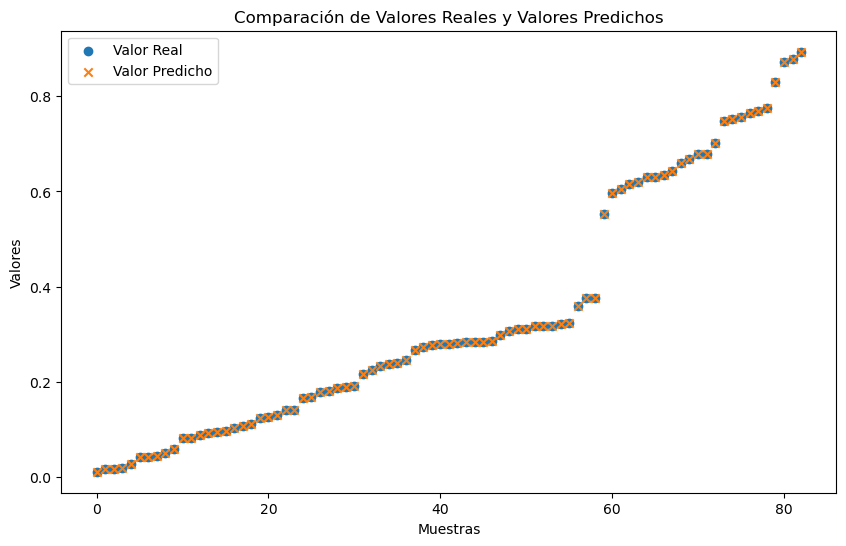

In [38]:
##visualizar modelo2

import matplotlib.pyplot as plt

# Crear un DataFrame con los valores originales y predichos
comparison_df = pd.DataFrame({'Valor Real': y_test, 'Valor Predicho': y_pred_test_lr})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df = comparison_df.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df)), comparison_df['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df)), comparison_df['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()


In [22]:
##pruebas de modelo
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_test_lr)
r2 = r2_score(y_test, y_pred_test_lr)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")


Error Cuadrático Medio (MSE): 7.998678826959754e-31
Coeficiente de Determinación (R²): 1.0


In [39]:
# Paso 1: Filtrar las filas para años a partir de 2017
filtered_data_2017 = reduced_df[reduced_df['Year'] >= 2017]
filtered_data_COL = reduced_df[reduced_df['Country'] == 'COL']

In [40]:



X_2017 = filtered_data_COL[['Country','CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_VA.EST']]
# Variables independientes
X_2017 = pd.get_dummies(filtered_data_COL, columns=['Country'], drop_first=True)

# Variable objetivo
y_2017 = filtered_data_COL['GDE_SL.GDP.PCAP.EM.KD']

# Paso 2: Realizar predicciones
y_pred_2017 = modelo.predict(X_2017)

# Paso 3: Evaluar el rendimiento del modelo
from sklearn.metrics import mean_squared_error, r2_score

mse_2017 = mean_squared_error(y_2017, y_pred_2017)
r2_2017 = r2_score(y_2017, y_pred_2017)

print(f"Error Cuadrático Medio (MSE) para 2017 en adelante: {mse_2017}")
print(f"Coeficiente de Determinación (R²) para 2017 en adelante: {r2_2017}")


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Country_BOL
- Country_BRA
- Country_CAN
- Country_CHL
- Country_CRI
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 8 features, but LinearRegression is expecting 25 features as input.

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear un DataFrame con la variable objetivo y las predicciones
comparison_df = pd.DataFrame({'Año': filtered_data_2017['Year'], 'Real': y_2017, 'Predicción': y_pred_2017})
comparison_df

,Año,Real,Predicción
0,2021,0.323422,0.323422
1,2020,0.331512,0.331512
2,2019,0.342874,0.342874
3,2018,0.359720,0.359720
4,2017,0.379654,0.379654
...,...,...,...
414,2021,1.000000,1.000000
415,2020,0.972540,0.972540
416,2019,0.943985,0.943985
417,2018,0.934198,0.934198


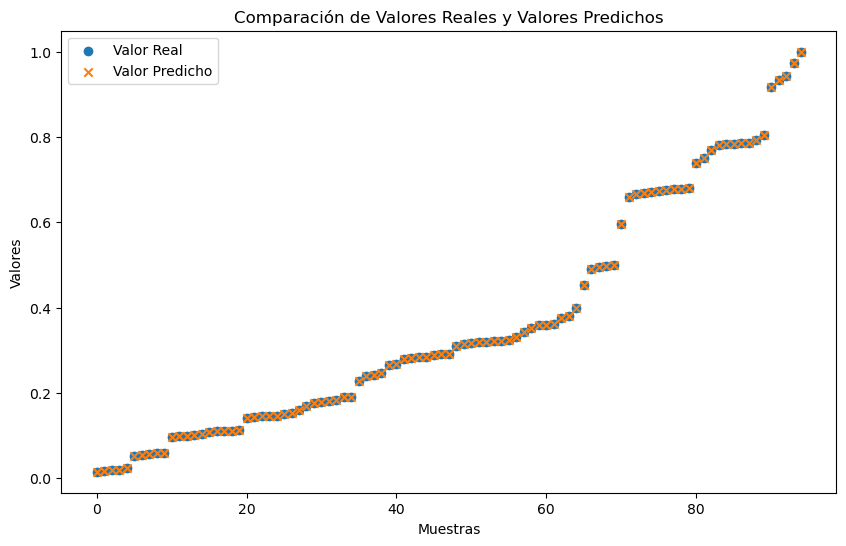

In [25]:
##visualizar modelo 2017

import matplotlib.pyplot as plt

# Crear un DataFrame con los valores originales y predichos
comparison_df = pd.DataFrame({'Valor Real': y_2017, 'Valor Predicho': y_pred_2017})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df = comparison_df.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df)), comparison_df['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df)), comparison_df['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()



In [26]:
##randomforest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 2, random_state=42)
rf.fit(X_train, y_train)

y_pred_test_rf = rf.predict(X_test)
y_pred_train_rf = rf.predict(X_train)

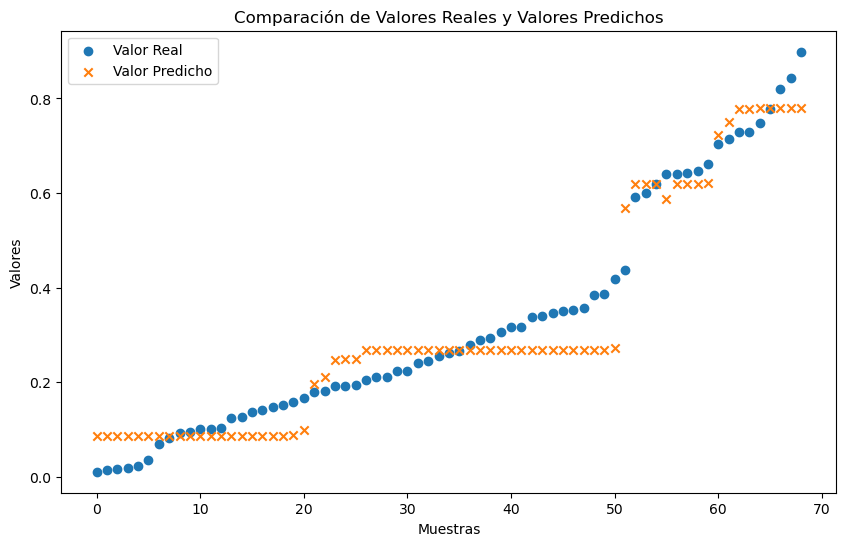

In [27]:
import matplotlib.pyplot as plt

# Crear un DataFrame con los valores originales y predichos
comparison_df = pd.DataFrame({'Valor Real': y_test, 'Valor Predicho': y_pred_test_rf})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df = comparison_df.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df)), comparison_df['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df)), comparison_df['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_test_rf)
r2 = r2_score(y_test, y_pred_test_rf)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")


Error Cuadrático Medio (MSE): 0.0032847387014062622
Coeficiente de Determinación (R²): 0.9435597970213514


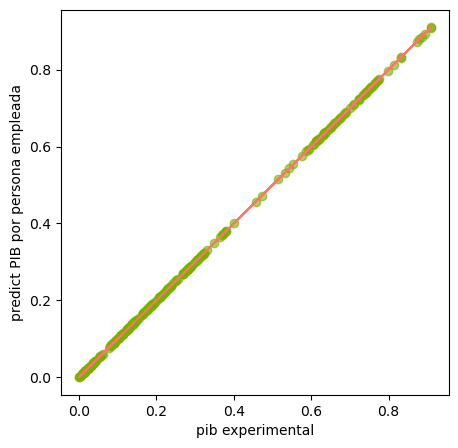

In [29]:
###Visualizar modelo

import numpy as np
plt.figure(figsize=(5,5))
plt.scatter(x= y_train, y=y_pred_train_lr,c = "#7CAE00",  alpha = 0.6)

z = np.polyfit(y_train, y_pred_train_lr,1)
p = np.poly1d(z)

plt.ylabel('predict PIB por persona empleada')
plt.xlabel('pib experimental')
plt.plot(y_train, p(y_train), "#F8766D")

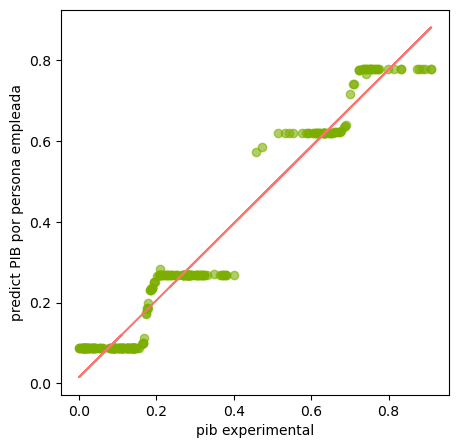

In [30]:
import numpy as np
plt.figure(figsize=(5,5))
plt.scatter(x= y_train, y=y_pred_train_rf,c = "#7CAE00",  alpha = 0.6)

z = np.polyfit(y_train, y_pred_train_rf,1)
p = np.poly1d(z)

plt.ylabel('predict PIB por persona empleada')
plt.xlabel('pib experimental')
plt.plot(y_train, p(y_train), "#F8766D")